In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**CT** (Computed Tomography) scans show a slice, or cross-section, of the body. The image shows your **bones, organs, and soft tissues** (like muscles) more clearly than standard x-rays. CT scans can show a tumor's shape, size, and location. They can even show the blood vessels that feed the tumor

*   *Tech*: 3D x-rays through the body, but radiations don't remain inside the body
*   *Detect and monitor*: body structure, internal blood vessels, fractures
*   Procedure time: 5-10mins max (so it's helpful in emergency diagnosis)
*   usually greyscale

**PET** (Positron emission tomography) scans are used to produce detailed 3D images of the inside of the body. The images can clearly show the part of the body being investigated, including any abnormal areas, and can highlight how well certain functions of the body are working.

*   *Tech*: injects a tiny amount of the radioactive tracer into a patient’s vein, usually on the inside of an elbow. After the injection, the tracer will move through the body and gather in tissues and organs. A patient will need to wait for about an hour for their body to absorb the tracer. Tracers will collect in tumors, inflamed areas or cancer cells for doctors to see.
After the tracer is absorbed, the patient will move to an exam table that slides into a scanner. The PET scanner will detect the tracer and turn the data into 3-D images on a computer monitor.
*   *Detect and monitor*: Cancer (quicklier than other tests, even in the earliest stages), Heart and Brain activities
*   *Procedure* time: 60-90mins because the body has to absorb the radioactive tracers
*   usually colorful and it should have a colorbar

Both are usually performed at an outpatient facility and do not require a hospital stay

Both can be used to detect cancer

Both are accurate, painless and noninvasive procedures

Both help eliminate the need for exploratory surgery

In [4]:
!pip install nilearn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


# CSV Generation

In [ ]:
import pandas as pd

benign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN'
malign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT'

directories = [benign_dir, malign_dir]
dataset = {'PET_mask_volume': [], 'CT_mask_volume': [], 'Glucose': [], 'y': []}
num_patients = 30

for directory in directories:
    patient_count = 0
    patients = [f.path for f in os.scandir(directory) if f.is_dir()]
    patients = sorted(patients)

    for patient in patients:
        patient_id = os.path.basename(patient)[:7]
        pet_scan_path = os.path.join(patient, f"{patient_id}_PT_partition.nii")
        pet_mask_path = os.path.join(patient, f"{patient_id}_PT_mask.nii")
        ct_scan_path = os.path.join(patient, f"{patient_id}_CT_partition.nii")
        ct_mask_path = os.path.join(patient, f"{patient_id}_CT_mask.nii")

        pet_scan = nib.load(pet_scan_path)
        pet_mask = nib.load(pet_mask_path)
        ct_scan = nib.load(ct_scan_path)
        ct_mask = nib.load(ct_mask_path)

        pet_voxel_size = pet_scan.header.get_zooms()
        pet_scan_data = pet_scan.get_fdata()
        pet_mask_data = pet_mask.get_fdata()

        ct_voxel_size = ct_scan.header.get_zooms()
        ct_scan_data = ct_scan.get_fdata()
        ct_mask_data = ct_mask.get_fdata()

        pet_mask_volume = np.sum(pet_mask_data == 1) * pet_voxel_size[0] * pet_voxel_size[1] * pet_voxel_size[2] / 1000
        ct_mask_volume = np.sum(ct_mask_data == 1) * ct_voxel_size[0] * ct_voxel_size[1] * ct_voxel_size[2] / 1000
        glucose = pet_scan_data[pet_mask_data.astype(bool)].mean()

        print(f"Patient {patient_id} pet mask volume: {pet_mask_volume:.2f} cm^3, ct mask volume: {ct_mask_volume.round(2)} cm^3, Glucose uptake: {glucose.round(2)}")
        dataset['PET_mask_volume'].append(pet_mask_volume)
        dataset['CT_mask_volume'].append(ct_mask_volume)
        dataset['Glucose'].append(glucose)

        if directory == malign_dir:
            dataset['y'].append(1)
        else:
            dataset['y'].append(0)

        patient_count += 1
        if patient_count == num_patients:
            break

df = pd.DataFrame(dataset).reset_index()
df

In [ ]:
df.to_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/lungs_masses.csv', index = False)

##if this is not the first time you run the code, run from HERE

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/lungs_masses.csv')
df

# Plots

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def plot_random_slices(directory_path):
    file_name = os.path.basename(directory_path)
    file_name = file_name.replace('_biobank', '')

    mask_ct_path = os.path.join(directory_path, f'{file_name}_CT_mask.nii')
    ct_path = os.path.join(directory_path, f'{file_name}_CT_partition.nii')
    mask_pet_path = os.path.join(directory_path, f'{file_name}_PT_mask.nii')
    pet_path = os.path.join(directory_path, f'{file_name}_PT_partition.nii')

    mask_ct = nib.load(mask_ct_path)
    ct = nib.load(ct_path)
    mask_pet = nib.load(mask_pet_path)
    pet = nib.load(pet_path)

    mask_ct_data = mask_ct.get_fdata()
    ct_data = ct.get_fdata()
    mask_pet_data = mask_pet.get_fdata()
    pet_data = pet.get_fdata()

    num_slices = ct_data.shape[2]
    slice_indices = np.random.choice(num_slices, size=4, replace=False)

    fig, axarr = plt.subplots(2, 2, figsize=(12, 6))

    for i, ax in enumerate(axarr.flat):
        if i < len(slice_indices):
            slice_index = slice_indices[i]
            ax.imshow(np.rot90(ct_data[:, :, slice_index], k=1), cmap='gray')
            ax.set_title(f'Slice {slice_index+1} CT')
            #ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def plot_random_slices(directory_path):
    file_name = os.path.basename(directory_path)
    file_name = file_name.replace('_biobank', '')

    mask_ct_path = os.path.join(directory_path, f'{file_name}_CT_mask.nii')
    ct_path = os.path.join(directory_path, f'{file_name}_CT_partition.nii')
    mask_pet_path = os.path.join(directory_path, f'{file_name}_PT_mask.nii')
    pet_path = os.path.join(directory_path, f'{file_name}_PT_partition.nii')

    mask_ct = nib.load(mask_ct_path)
    ct = nib.load(ct_path)
    mask_pet = nib.load(mask_pet_path)
    pet = nib.load(pet_path)

    mask_ct_data = mask_ct.get_fdata()
    ct_data = ct.get_fdata()
    mask_pet_data = mask_pet.get_fdata()
    pet_data = pet.get_fdata()

    num_slices = pet_data.shape[2]
    slice_indices = np.random.choice(num_slices, size=4, replace=False)

    fig, axarr = plt.subplots(2, 2, figsize=(12, 6))

    for i, ax in enumerate(axarr.flat):
        if i < len(slice_indices):
            slice_index = slice_indices[i]
            ax.imshow(np.rot90(pet_data[:, :, slice_index], k=1), cmap='hot')
            ax.set_title(f'Slice {slice_index+1} PET')
            #ax.axis('off')

    plt.tight_layout()
    plt.show()


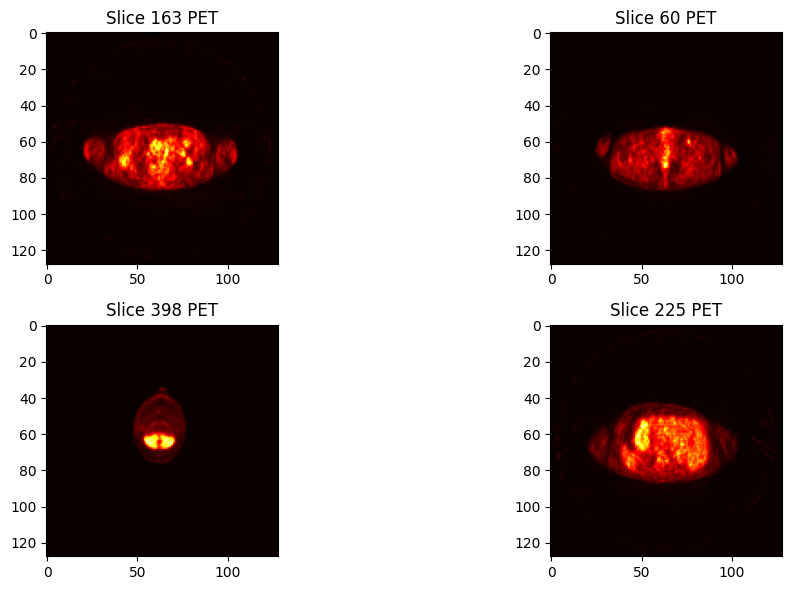

In [ ]:
plot_random_slices('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank')

In [5]:
test_pet_scan_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_partition.nii'
test_pet_mask_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_mask.nii'
test_ct_scan_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_CT_partition.nii'
test_ct_mask_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_CT_mask.nii'

test_pet_scan = nib.load(test_pet_scan_path)
test_pet_mask = nib.load(test_pet_mask_path)
test_ct_scan = nib.load(test_ct_scan_path)
test_ct_mask = nib.load(test_ct_mask_path)

test_pet_scan_data = test_pet_scan.get_fdata()
test_pet_mask_data = test_pet_mask.get_fdata()

test_ct_scan_data = test_ct_scan.get_fdata()
test_ct_mask_data = test_ct_mask.get_fdata()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

def plot_slices_with_mask_overlay(ct_scan_data, ct_mask_data, pet_scan_data, pet_mask_data):
    # Create custom colormaps for CT and PET scans
    ct_cmap = plt.cm.gray
    pet_cmap = plt.cm.hot

    # Plot CT scan with mask overlay
    display = plotting.plot_roi(ct_mask_data, bg_img=ct_scan_data, cmap=ct_cmap, alpha=0.5, display_mode='ortho',
                                cut_coords=None, colorbar=False, title='CT Scan with Mask Overlay')
    plotting.show()

    # Plot PET scan with mask overlay
    display = plotting.plot_roi(pet_mask_data, bg_img=pet_scan_data, cmap=pet_cmap, alpha=0.5, display_mode='ortho',
                                cut_coords=None, colorbar=False, title='PET Scan with Mask Overlay')
    plotting.show()


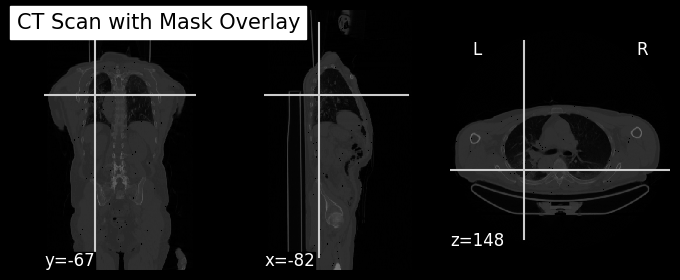

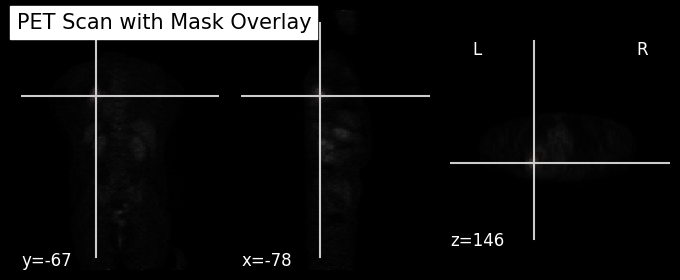

In [15]:
plot_slices_with_mask_overlay(test_ct_scan, test_ct_mask, test_pet_scan, test_pet_mask)

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def plot_rotated_scans_with_mask(ct_scan_path, ct_mask_path, pet_scan_path, pet_mask_path):
    # Load the CT scan and mask
    ct_scan = nib.load(ct_scan_path)
    ct_mask = nib.load(ct_mask_path)

    # Load the PET scan and mask
    pet_scan = nib.load(pet_scan_path)
    pet_mask = nib.load(pet_mask_path)

    # Get the data arrays
    ct_scan_data = ct_scan.get_fdata()
    ct_mask_data = ct_mask.get_fdata()
    pet_scan_data = pet_scan.get_fdata()
    pet_mask_data = pet_mask.get_fdata()

    # Rotate the CT scan and mask by 90 degrees
    rotated_ct_scan_data = np.rot90(ct_scan_data)
    rotated_ct_mask_data = np.rot90(ct_mask_data)

    # Rotate the PET scan and mask by 90 degrees
    rotated_pet_scan_data = np.rot90(pet_scan_data)
    rotated_pet_mask_data = np.rot90(pet_mask_data)

    # Find the slice index where the mass is present for CT scan
    ct_slice_index = np.where(rotated_ct_mask_data > 0)
    ct_slice_index = ct_slice_index[0][0]
    ct_slice_data = rotated_ct_scan_data[ct_slice_index, :, :]

    # Find the slice index where the mass is present for PET scan
    pet_slice_index = np.where(rotated_pet_mask_data > 0)
    pet_slice_index = pet_slice_index[0][0]
    pet_slice_data = rotated_pet_scan_data[pet_slice_index, :, :]

    # Plot the rotated CT scan
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.imshow(ct_slice_data, cmap='gray')
    plt.axis('off')
    plt.title('Rotated CT Scan Slice')

    # Plot the rotated CT scan with the mask overlayed
    plt.subplot(222)
    plt.imshow(ct_slice_data, cmap='gray')
    plt.contour(rotated_ct_mask_data[ct_slice_index, :, :], colors='r', linewidths=2)
    plt.axis('off')
    plt.title('Rotated CT Scan with Mask Overlay')

    # Plot the rotated PET scan
    plt.subplot(223)
    plt.imshow(pet_slice_data, cmap='hot')
    plt.axis('off')
    plt.title('Rotated PET Scan Slice')

    # Plot the rotated PET scan with the mask overlayed
    plt.subplot(224)
    plt.imshow(pet_slice_data, cmap='hot')
    plt.contour(rotated_pet_mask_data[pet_slice_index, :, :], colors='r', linewidths=2)
    plt.axis('off')
    plt.title('Rotated PET Scan with Mask Overlay')

    plt.tight_layout()
    plt.show()


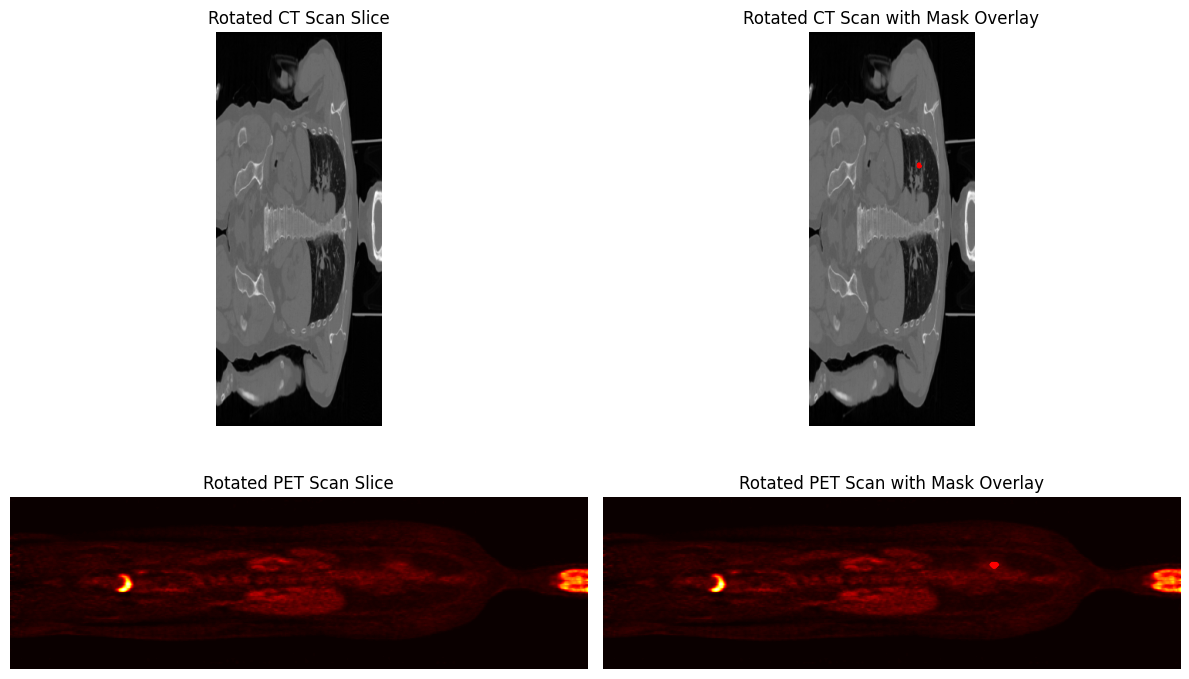

In [ ]:
plot_rotated_scans_with_mask(test_ct_scan_path, test_ct_mask_path, test_pet_scan_path, test_pet_mask_path)

# **Models**

In [ ]:
from sklearn.preprocessing import StandardScaler
X = df.drop(columns = 'y', axis = 1)
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
y = df['y']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_norm, y, train_size=0.6, random_state=True)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def hyperparameter_tuning(X_train, X_val, y_train, y_val):
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['poly', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10]
    }

    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, scoring='accuracy')
    svm_grid_search.fit(X_train, y_train)

    rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, scoring='accuracy')
    rf_grid_search.fit(X_train, y_train)

    best_svm_model = svm_grid_search.best_estimator_
    best_svm_params = svm_grid_search.best_params_

    best_rf_model = rf_grid_search.best_estimator_
    best_rf_params = rf_grid_search.best_params_

    svm_y_pred = best_svm_model.predict(X_val)
    svm_accuracy = accuracy_score(y_val, svm_y_pred)
    svm_precision = precision_score(y_val, svm_y_pred)
    svm_recall = recall_score(y_val, svm_y_pred)
    svm_f1 = f1_score(y_val, svm_y_pred)
    svm_confusion_matrix = confusion_matrix(y_val, svm_y_pred)

    rf_y_pred = best_rf_model.predict(X_val)
    rf_accuracy = accuracy_score(y_val, rf_y_pred)
    rf_precision = precision_score(y_val, rf_y_pred)
    rf_recall = recall_score(y_val, rf_y_pred)
    rf_f1 = f1_score(y_val, rf_y_pred)
    rf_confusion_matrix = confusion_matrix(y_val, rf_y_pred)

    metrics = ['Accuracy', 'Sensitivity', 'Specificity']
    svm_scores = [svm_accuracy, svm_recall, svm_precision]
    rf_scores = [rf_accuracy, rf_recall, rf_precision]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, svm_scores, width, label='SVM')
    rects2 = ax.bar(x + width/2, rf_scores, width, label='RF')

    print("SVM scores: ", svm_scores)
    print("RF scores: ", rf_scores)

    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    fig.tight_layout()

    plt.show()

    if svm_accuracy > rf_accuracy:
        best_model_name = 'SVM'
        best_model_params = best_svm_params
    else:
        best_model_name = 'RF'
        best_model_params = best_rf_params

    return best_model_name, best_model_params, svm_confusion_matrix, rf_confusion_matrix


SVM scores:  [0.9583333333333334, 0.9333333333333333, 1.0]
RF scores:  [1.0, 1.0, 1.0]


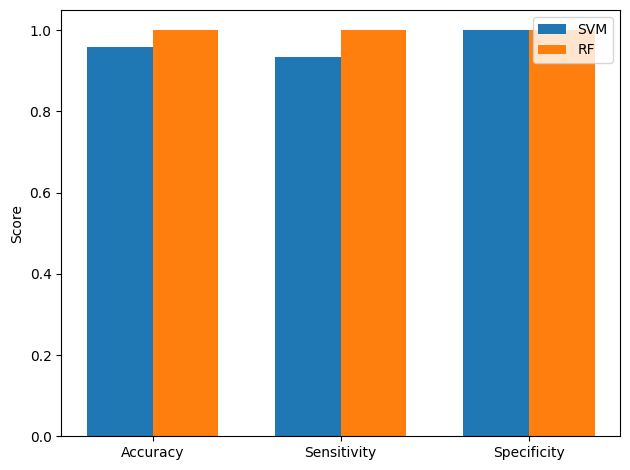

In [ ]:
best_model_name, best_model_params, svm_confusion_matrix, rf_confusion_matrix = hyperparameter_tuning(X_train, X_val, y_train, y_val)

In [ ]:
print('Best model:', best_model_name)
print('Best model params:', best_model_params)

Best model: RF
Best model params: {'max_depth': None, 'n_estimators': 50}


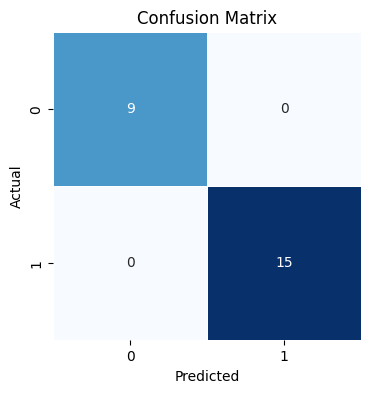

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
                square=True, linewidths=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Usage example
plot_confusion_matrix(rf_confusion_matrix)


**PyRadiomics**

In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 32.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 41.9 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp310-cp310-linux_x86_64.whl size=186234 sha256=f2473d3cc4ca0ad7a9160f1868acdcf8503cc5899ef01b462269291a37a0799a
  Stored in directory: /root/.cache/pip/wheels/91/c5/13/c5fd4c5ad3edf4062bb3855bd66fad25871c9c6dc0b3fda544
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=dcb9cfb11ed53426803912f8468d0875b6b5cc09617b919129f81c5561faf449
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da20

In [ ]:
import os
import pandas as pd
import SimpleITK as sitk
import radiomics

benign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN'
malign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT'

directories = [benign_dir, malign_dir]
dataset = {'Patient': [], 'Label': []}

extractor = radiomics.featureextractor.RadiomicsFeatureExtractor()

extractor.settings["enableAllImageTypes"] = False

num_patients = 30
for directory in directories:
    patient_count = 0
    patients = [f.path for f in os.scandir(directory) if f.is_dir()]
    patients = sorted(patients)

    for patient in patients:
        patient_id = os.path.basename(patient)[:7]
        pet_scan_path = os.path.join(patient, f"{patient_id}_PT_partition.nii")
        pet_mask_path = os.path.join(patient, f"{patient_id}_PT_mask.nii")
        ct_scan_path = os.path.join(patient, f"{patient_id}_CT_partition.nii")
        ct_mask_path = os.path.join(patient, f"{patient_id}_CT_mask.nii")

        pet_scan = sitk.ReadImage(pet_scan_path)
        pet_mask = sitk.ReadImage(pet_mask_path)
        ct_scan = sitk.ReadImage(ct_scan_path)
        ct_mask = sitk.ReadImage(ct_mask_path)

        pet_features = extractor.execute(pet_scan, pet_mask)
        ct_features = extractor.execute(ct_scan, ct_mask)

        dataset['Patient'].append(patient_id)
        dataset['Label'].append(1 if directory == malign_dir else 0)
        for feature_name, feature_value in pet_features.items():
            dataset[feature_name + '_PET'] = dataset.get(feature_name + '_PET', [])
            dataset[feature_name + '_PET'].append(feature_value)
        for feature_name, feature_value in ct_features.items():
            dataset[feature_name + '_CT'] = dataset.get(feature_name + '_CT', [])
            dataset[feature_name + '_CT'].append(feature_value)

        patient_count += 1
        if patient_count == num_patients:
            break

df = pd.DataFrame(dataset)
df.to_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/radiomics_dataset.csv', index=False)


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firsto

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/radiomics_dataset_num.csv')

In [ ]:
df.head()

,Label,original_shape_Elongation_PET,original_shape_Flatness_PET,original_shape_LeastAxisLength_PET,original_shape_MajorAxisLength_PET,original_shape_Maximum2DDiameterColumn_PET,original_shape_Maximum2DDiameterRow_PET,original_shape_Maximum2DDiameterSlice_PET,original_shape_Maximum3DDiameter_PET,original_shape_MeshVolume_PET,...,original_glszm_SmallAreaHighGrayLevelEmphasis_CT,original_glszm_SmallAreaLowGrayLevelEmphasis_CT,original_glszm_ZoneEntropy_CT,original_glszm_ZonePercentage_CT,original_glszm_ZoneVariance_CT,original_ngtdm_Busyness_CT,original_ngtdm_Coarseness_CT,original_ngtdm_Complexity_CT,original_ngtdm_Contrast_CT,original_ngtdm_Strength_CT
0,0,0.661940,0.508343,15.932745,31.342481,26.663361,34.922819,32.435116,35.327563,7034.903304,...,92.235755,0.007795,6.053546,0.297853,60.091515,0.447742,0.006600,522.880348,0.230369,1.196868
1,0,0.503239,0.371461,16.023878,43.137415,25.209692,45.836477,41.106670,47.043966,5023.357769,...,34.643343,0.025884,4.986530,0.105852,3331.266434,1.336081,0.003777,82.654938,0.032148,0.396907
2,0,0.636190,0.413243,14.756147,35.708176,25.940559,37.191521,38.085437,38.958847,7653.017839,...,130.634676,0.009849,5.710240,0.453721,7.786384,0.263886,0.013716,521.332404,0.240932,2.249259
3,0,0.865538,0.560351,18.652888,33.287875,38.669902,39.813101,39.150292,43.578766,11379.008492,...,101.572552,0.013002,6.705682,0.263557,50.859823,0.828583,0.004215,594.488045,0.204413,1.082147
4,0,0.657524,0.441164,11.287832,25.586468,19.906550,30.571242,31.176672,32.121633,3152.695795,...,128.227473,0.015377,5.322593,0.478261,6.214876,0.123396,0.024678,530.542735,0.289571,4.255454


In [ ]:
filtered_df = df.select_dtypes(include=[np.number]).drop(columns=[col for col in df.columns if 'diagnostics_' in col])
df = filtered_df
df.head()
df.to_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/radiomics_dataset_num.csv', index=False)

KeyError: ignored

In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

radiomics_dataset = pd.read_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/radiomics_dataset_num.csv')

X = radiomics_dataset.drop('Label', axis=1)
y = radiomics_dataset['Label']

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_normalized)

num_features = X_pca.shape[1]
print(f"Number of features after PCA: {num_features}")

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

Number of features after PCA: 10


SVM scores:  [0.9166666666666666, 0.875, 1.0]
RF scores:  [0.9166666666666666, 0.875, 1.0]


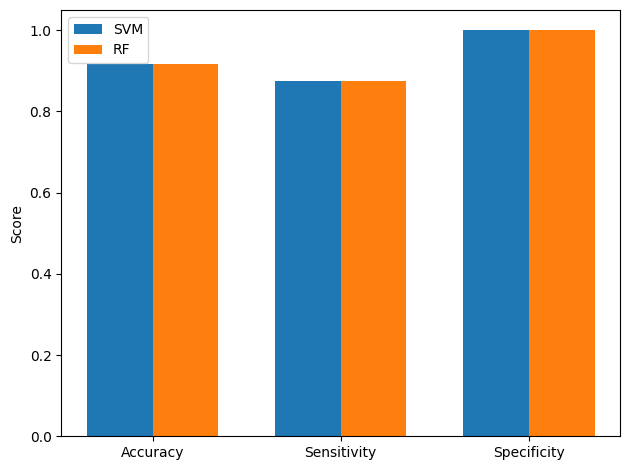

In [ ]:
best_model_name, best_model_params, svm_confusion_matrix, rf_confusion_matrix = hyperparameter_tuning(X_train, X_test, y_train, y_test)

In [ ]:
print('Best model:', best_model_name)
print('Best model params:', best_model_params)

Best model: RF
Best model params: {'max_depth': 5, 'n_estimators': 200}


In [ ]:
best_model_params

{'max_depth': 5, 'n_estimators': 200}

In [ ]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


rf_classifier = RandomForestClassifier(**best_model_params)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(rf_classifier, X_pca, y, cv=kfold)

print("Cross-validation scores:")
for fold, score in enumerate(cross_val_scores):
    print(f"Fold {fold + 1}: {score:.2f}")
print(f"Mean Accuracy: {cross_val_scores.mean():.2f}")

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.92
Sensitivity: 0.88
Specificity: 1.00
Cross-validation scores:
Fold 1: 1.00
Fold 2: 0.92
Fold 3: 0.83
Fold 4: 0.92
Fold 5: 0.75
Mean Accuracy: 0.88
Confusion Matrix:
[[4 0]
 [1 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



In [ ]:
CT_imagepath = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_CT_partition.nii'
CT_maskpath = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_CT_mask.nii'

PET_imagepath='/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_partition.nii'
PET_maskpath='/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT/LCp0016_biobank/LCp0016_PT_mask.nii'

In [ ]:
result = extractor.execute(CT_imagepath, CT_maskpath)
variance_ratio = pca.explained_variance_ratio_

feature_names = list(result.keys())

feat_variances = [(feat, var) for feat, var in zip(feature_names, pca.explained_variance_ratio_)]

feat_variances_sorted = sorted(feat_variances, key=lambda x: x[1], reverse=True)

for feat, var in feat_variances_sorted:
    print(feat, var)

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


diagnostics_Versions_PyRadiomics 0.38662787543450333
diagnostics_Versions_Numpy 0.17085888347042696
diagnostics_Versions_SimpleITK 0.11112550635943214
diagnostics_Versions_PyWavelet 0.07200431395334927
diagnostics_Versions_Python 0.04754370509287343
diagnostics_Configuration_Settings 0.033075548512762426
diagnostics_Configuration_EnabledImageTypes 0.030081251864212014
diagnostics_Image-original_Hash 0.023073406275128588
diagnostics_Image-original_Dimensionality 0.01896004598484243
diagnostics_Image-original_Spacing 0.013638261250871286


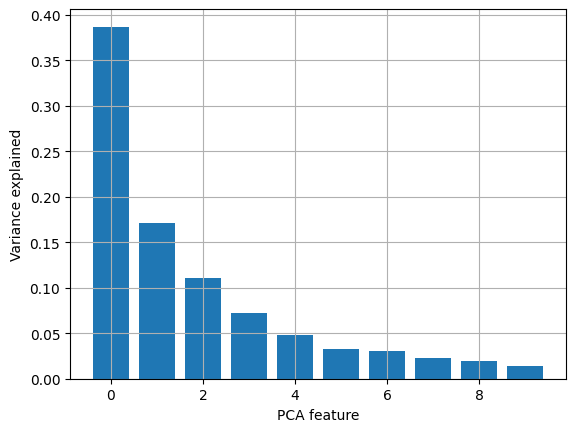

In [ ]:
#plot variances
plt.bar(range(len(variance_ratio)), variance_ratio)
plt.xlabel('PCA feature')
plt.ylabel('Variance explained')
plt.grid()
plt.show()

**Radiomics** is the process of quantitative properties extraction (named features) from an image or from a specifed ROI (region of interest) identified in an image manually or automatically.

Feature extraction activity is typically realized by means of pattern recognition algorithms and provides, as a result, a set of numbers, each one representing a quantitative description of a specifiic either geometrical or physical property of the image portion under consideration.

Radiomics purpose in diagnosis: increasing the accuracy (benign vs malignant), enhancing the possibility of classify different malignant lesions

key steps: converting .nii images to greyscale, then you can extract the features (they're many so pick a subset) from every PET and CT scans applied to the respective mask. 

PCA to reduce dimensionality and then classification

# CNN

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/lungs_masses.csv')


In [ ]:
import os

benign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN'
malign_dir = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS1_MALIGNANT'

directories = [benign_dir, malign_dir]
file_paths = []

for directory in directories:
    patients = [f.path for f in os.scandir(directory) if f.is_dir()]
    patients = sorted(patients)

    for patient in patients:
        patient_id = os.path.basename(patient)[:7]
        pet_scan_path = os.path.join(patient, f"{patient_id}_PT_partition.nii")
        pet_mask_path = os.path.join(patient, f"{patient_id}_PT_mask.nii")
        ct_scan_path = os.path.join(patient, f"{patient_id}_CT_partition.nii")
        ct_mask_path = os.path.join(patient, f"{patient_id}_CT_mask.nii")

        file_paths.append([pet_scan_path, pet_mask_path, ct_scan_path, ct_mask_path])

for sub_list in file_paths:
    print(sub_list)


['/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_PT_partition.nii', '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_PT_mask.nii', '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_partition.nii', '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_mask.nii']
['/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0002_biobank/LCp0002_PT_partition.nii', '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0002_biobank/LCp0002_PT_mask.nii', '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-

In [ ]:
partitions_files = [y[2] for y in file_paths]
mask_files = [y[3] for y in file_paths]
print(len(partitions_files))
print(len(partitions_files[10:]))
print(len(partitions_files[:10]))

60
50
10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

mask_file = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_mask.nii'
partition_file = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_partition.nii'

mask_data = nib.load(mask_file).get_fdata()
partition_data = nib.load(partition_file).get_fdata()

slices_with_mass = np.unique(np.where(mask_data > 0)[2])

for slice_idx in slices_with_mass:
    plt.figure()
    plt.imshow(partition_data[:, :, slice_idx], cmap='gray')
    plt.contour(mask_data[:, :, slice_idx], colors='r', linewidths=1)
    plt.title(f"Slice {slice_idx + 1}")
    plt.axis('off')
    plt.show()




In [ ]:
!pip install --upgrade nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class CropTransform(object):
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, image):
        channels, height, width = image.shape

        # Calculate the coordinates for cropping
        start_h = max(0, height // 2 - self.crop_size // 2)
        end_h = start_h + self.crop_size
        start_w = max(0, width // 2 - self.crop_size // 2)
        end_w = start_w + self.crop_size

        # Crop the image
        cropped_image = image[:, start_h:end_h, start_w:end_w]

        return cropped_image


In [ ]:
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, ct_paths, mask_paths, transform=None):
        self.ct_paths = ct_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mass_slices = self.find_mass_slices()

    def __len__(self):
        return len(self.mass_slices)

    def __getitem__(self, idx):
      file_idx, slice_idx = self.mass_slices[idx]
      ct_path = self.ct_paths[file_idx]
      mask_path = self.mask_paths[file_idx]

      ct_scan = nib.load(ct_path)
      mask = nib.load(mask_path)

      ct_scan_data = ct_scan.get_fdata()
      mask_data = mask.get_fdata()

      ct_slice = ct_scan_data[:, :, slice_idx]
      mask_slice = mask_data[:, :, slice_idx]

      # Convert the CT slice to 3 channels
      ct_slice = np.stack([ct_slice] * 3, axis=0)  # Transpose dimensions to [channels, height, width]

      ct_slice = ct_slice.astype(np.float32)
      mask_slice = mask_slice.astype(np.float32)

      if self.transform:
          ct_slice = self.transform(ct_slice)

      mask_slice = (mask_slice > 0).astype(np.float32)

      ct_slice = torch.from_numpy(ct_slice)
      mask_slice = torch.from_numpy(mask_slice)

      return ct_slice, mask_slice


    def find_mass_slices(self):
        mass_slices = []
        for i, mask_path in enumerate(self.mask_paths):
            mask = nib.load(mask_path)
            mask_data = mask.get_fdata()

            current_mass_slices = np.where(mask_data > 0)[2]
            mass_slices.extend([(i, slice_idx) for slice_idx in current_mass_slices])

        return mass_slices

crop_size = 32  # Adjust the crop size as per your requirements

resize_transform = transforms.Compose([
    CropTransform(crop_size),
    #transforms.ToTensor()
])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

train_ct_scans = partitions_files[10:]
train_masks = mask_files[10:]

val_ct_scans = partitions_files[:10]
val_masks = mask_files[:10]

num_classes = 1

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[-1] = nn.Conv2d(model.classifier[-1].in_channels, num_classes, kernel_size=1)

criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train_dataset = CustomDataset(train_ct_scans, train_masks, resize_transform)
val_dataset = CustomDataset(val_ct_scans, val_masks, resize_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.train()

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)

        outputs = model(inputs)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_masks in val_loader:
            val_inputs = val_inputs.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_inputs)["out"]
            val_loss += criterion(val_outputs, val_masks).item()

    print(f"Validation Loss: {val_loss / len(val_loader)}")


ValueError: ignored

In [ ]:
'/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_partition.nii'


In [ ]:
!pip install segmentation-models-pytorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=8b4a147a84ded4240cd6b087097a36e20b634648b36ea5698c66d12495739df0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=dfcc99fdb476b89625094f1dbbdef713988082e9c088047f685130717e9b09a4
  Stored in directory: /root/.cache/pip/w

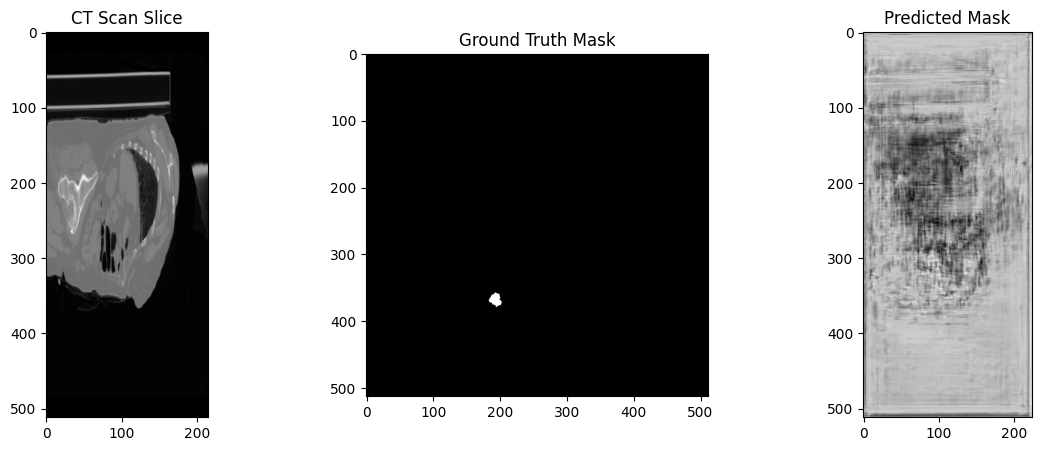

In [ ]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Preprocess the CT scan data
def preprocess_ct_scan(ct_scan_path):
    ct_scan = nib.load(ct_scan_path)
    ct_scan_data = ct_scan.get_fdata()
    ct_scan_data = (ct_scan_data - np.min(ct_scan_data)) / (np.max(ct_scan_data) - np.min(ct_scan_data))
    ct_scan_data = np.expand_dims(ct_scan_data, axis=0)
    return torch.tensor(ct_scan_data, dtype=torch.float32)

# Load the pretrained U-Net model
model = smp.Unet('resnet34', encoder_weights='imagenet')

# Load the CT scan
ct_scan_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_partition.nii'

ct_scan_data = preprocess_ct_scan(ct_scan_path)

# Load the ground truth mask
gt_mask_path = '/content/drive/MyDrive/MSc/Healthcare/Project no. 2 - PET-CT/Castiglioni_masse_polmonari_laboratorio/CLASS2_BENIGN/LCp0001_biobank/LCp0001_CT_mask.nii'

gt_mask_data = nib.load(gt_mask_path).get_fdata()

# Find the slice indices with a mass in the ground truth mask
mass_slice_indices = np.where(np.sum(gt_mask_data, axis=(0, 1)) > 0)[0]

# Randomly select one slice with a mass
selected_index = np.random.choice(mass_slice_indices)
ct_scan_slice = ct_scan_data[:, selected_index, :, :]

# Convert CT scan slice tensor to PIL Image
ct_scan_slice_pil = transforms.ToPILImage()(ct_scan_slice)

# Define the transform to resize and normalize the input image
transform = transforms.Compose([
    transforms.Resize((512, 224)),  # Resize to smaller dimensions
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Apply the transform to the CT scan slice
ct_scan_slice_normalized = transform(ct_scan_slice_pil)

# Repeat the single channel to create 3 channels
ct_scan_slice_normalized = torch.cat([ct_scan_slice_normalized] * 3)

# Expand dimensions to match the model input
ct_scan_slice_normalized = ct_scan_slice_normalized.unsqueeze(0)

# Generate the predicted mask
model.eval()
with torch.no_grad():
    output = model(ct_scan_slice_normalized)
    predicted_mask = torch.sigmoid(output).squeeze().numpy()

# Plot the CT scan, ground truth mask, and the predicted mask side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ct_scan_slice.squeeze(), cmap='gray')
axes[0].set_title('CT Scan Slice')

axes[1].imshow(gt_mask_data[..., selected_index], cmap='gray')
axes[1].set_title('Ground Truth Mask')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Predicted Mask')

plt.show()

In [ ]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CTDataset(Dataset):
    def __init__(self, ct_paths, mask_paths, transform=None):
        self.ct_paths = ct_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.ct_paths)

    def __getitem__(self, idx):
        ct_path = self.ct_paths[idx]
        mask_path = self.mask_paths[idx]

        ct_scan = nib.load(ct_path)
        ct_scan_data = ct_scan.get_fdata()
        ct_scan_data = (ct_scan_data - np.min(ct_scan_data)) / (np.max(ct_scan_data) - np.min(ct_scan_data))

        # Convert to 3D if 4D
        if ct_scan_data.ndim == 4:
            ct_scan_data = np.squeeze(ct_scan_data, axis=-1)

        ct_scan_data = np.expand_dims(ct_scan_data, axis=0)
        ct_scan_data = torch.tensor(ct_scan_data, dtype=torch.float32)

        gt_mask = nib.load(mask_path).get_fdata()
        gt_mask = torch.tensor(gt_mask, dtype=torch.float32)

        if self.transform:
            ct_scan_data = self.transform(ct_scan_data)

        return ct_scan_data, gt_mask

# List of CT scans and ground truth masks
ct_paths = partitions_files
mask_paths = mask_files

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# Create the custom dataset
dataset = CTDataset(ct_paths, mask_paths, transform=transform)

# Split the dataset into training and validation subsets
train_indices = range(0, int(0.8 * len(dataset)))  # 80% for training
val_indices = range(int(0.8 * len(dataset)), len(dataset))  # 20% for validation

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load the pretrained U-Net model
model = smp.Unet('resnet34', encoder_weights='imagenet')

# Modify the model for binary segmentation
model.segmentation_head = nn.Conv2d(model.encoder.out_channels[-1], 1, kernel_size=1)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for ct_scan_data, gt_mask in train_loader:
        optimizer.zero_grad()

        output = model(ct_scan_data)
        loss = criterion(output, gt_mask)

        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for ct_scan_data, gt_mask in val_loader:
            output = model(ct_scan_data)
            loss = criterion(output, gt_mask)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'fine_tuned_unet.pt')


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

import numpy as np
import nibabel as nib

# Pretrained U-Net model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32,
                       pretrained=False)

# Custom dataset for loading and preprocessing CT scans and masks
class CTDataset(Dataset):
    def __init__(self, partitions_files, mask_files):
        self.partitions_files = partitions_files
        self.mask_files = mask_files

    def __len__(self):
        return len(self.partitions_files)

    def __getitem__(self, idx):
        ct_scan = nib.load(self.partitions_files[idx]).get_fdata()
        mask = nib.load(self.mask_files[idx]).get_fdata()

        # Check if the mask contains a mass
        if np.sum(mask) > 0:
            # Get the corresponding CT slices and masks
            slices = []
            masks = []
            for slice_idx in range(ct_scan.shape[-1]):
                slice_data = ct_scan[..., slice_idx]
                mask_data = mask[..., slice_idx]
                slices.append(slice_data)
                masks.append(mask_data)

            # Convert lists to NumPy arrays
            slices = np.array(slices)
            masks = np.array(masks)

            # Reshape slices to have 1 channel
            slices = np.expand_dims(slices, axis=1)

            return torch.from_numpy(slices).float(), torch.from_numpy(masks).float()

        # Return None if the mask does not contain a mass
        return None, None

# Create the dataset and data loader
dataset = CTDataset(partitions_files, mask_files)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Modify the number of input channels in the model
model.inc = DoubleConv(1, 32)

# Prepare the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for slices, masks in data_loader:
        slices = slices.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(slices)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Print epoch statistics
    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_model.pth")


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


NameError: ignored

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import nibabel as nib
import torchvision.transforms as transforms
import torchvision.models as models

# Define your custom dataset class
class CTDataset(Dataset):
    def __init__(self, scan_files, mask_files):
        self.scan_files = scan_files
        self.mask_files = mask_files
        self.mass_slices = []

        for scan_file, mask_file in zip(scan_files, mask_files):
            scans = nib.load(scan_file).get_fdata()
            masks = nib.load(mask_file).get_fdata()

            # Find the slices that contain a mass
            mass_slices = np.where(np.sum(masks, axis=(0, 1)) > 0)[0]
            self.mass_slices.extend([(scan_file, mask_file, slice_idx) for slice_idx in mass_slices])

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Modify mean and std according to your data
        ])

    def __len__(self):
        return len(self.mass_slices)  # Number of slices with a mass

    def __getitem__(self, idx):
        scan_file, mask_file, slice_idx = self.mass_slices[idx]

        scan_slice = nib.load(scan_file).get_fdata()[:, :, slice_idx]
        mask_slice = nib.load(mask_file).get_fdata()[:, :, slice_idx]

        # Perform normalization and resizing
        scan_tensor = self.transform(scan_slice)
        mask_tensor = self.transform(mask_slice)

        return scan_tensor, mask_tensor

# Define your pretrained segmentation model (replace with your own architecture)
pretrained_model = models.segmentation.deeplabv3_resnet50(pretrained=True)
pretrained_model.classifier[-1] = nn.Conv2d(256, 1, kernel_size=(1, 1))

# Set the paths to your CT scans and masks
scan_files = partitions_files  # Replace with your scan file paths
mask_files = mask_files  # Replace with your mask file paths

# Create instances of the dataset and dataloader
dataset = CTDataset(scan_files, mask_files)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Training loop
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

for epoch in range(epochs):
    running_loss = 0.0

    for scans, masks in dataloader:
        scans = scans.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_model(scans)['out']
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1}/{epochs} Loss: {running_loss / len(dataloader)}")

# Save the trained model
torch.save(pretrained_model.state_dict(), "path_to_trained_model.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: ignored

# Simple NN

In [ ]:
#pytorch nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def network_defiition(X_train, y_train, num_epochs=100, batch_size=32, learning_rate=0.001, hidden_size=64):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    model.add(Dense(8, activation='relu', input_dim=10))#CHAGE TO YOUR nUMBER OF FEATURES
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
neural=network_defiition(X_train, y_train, num_epochs=135)
neural.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
neural.fit(X_train, y_train, epochs=135, batch_size=16, verbose=1)

Epoch 1/135
3/3 [==============================] - 2s 8ms/step - loss: 0.9197 - accuracy: 0.4792
Epoch 2/135
3/3 [==============================] - 0s 8ms/step - loss: 0.8506 - accuracy: 0.5000
Epoch 3/135
3/3 [==============================] - 0s 8ms/step - loss: 0.8022 - accuracy: 0.5208
Epoch 4/135
3/3 [==============================] - 0s 8ms/step - loss: 0.7510 - accuracy: 0.5833
Epoch 5/135
3/3 [==============================] - 0s 8ms/step - loss: 0.7099 - accuracy: 0.6042
Epoch 6/135
3/3 [==============================] - 0s 7ms/step - loss: 0.6713 - accuracy: 0.6667
Epoch 7/135
3/3 [==============================] - 0s 9ms/step - loss: 0.6345 - accuracy: 0.7500
Epoch 8/135
3/3 [==============================] - 0s 7ms/step - loss: 0.6031 - accuracy: 0.7500
Epoch 9/135
3/3 [==============================] - 0s 8ms/step - loss: 0.5698 - accuracy: 0.7500
Epoch 10/135
3/3 [==============================] - 0s 6ms/step - loss: 0.5448 - accuracy: 0.7917
Epoch 11/135
3/3 [===========

In [ ]:
neural.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


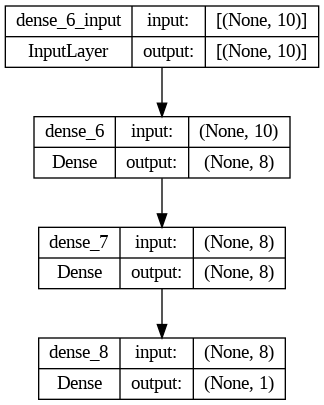

In [ ]:
from keras.utils import plot_model
plot_model(neural, to_file='/tmp/model.png', show_shapes=True)

In [ ]:
y_pred = neural.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
#accuracy model 
score = neural.evaluate(X_test, y_test,verbose=1)
print(score)

1/1 [==============================] - 0s 284ms/step - loss: 0.4703 - accuracy: 0.8333
[0.47032031416893005, 0.8333333134651184]


In [ ]:
from sklearn.metrics import auc, roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

AUC is the percentage of this area that is under this ROC (Receiver operating characteristic) curve, ranging between 0~1.  

What can they do?

ROC is a great way to visualize the performance of a binary classifier, and AUC is one single number to summarize a classifier's performance by assessing the ranking regarding separation of the two classes. The higher, the better.

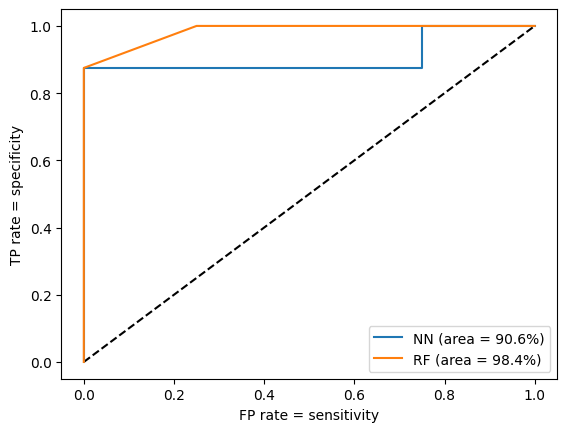

In [ ]:
#def plot_roc_NNrf():
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='NN (area = {:.1f}%)'.format(auc_keras*100))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.1f}%)'.format(auc_rf*100))
plt.xlabel('FP rate = sensitivity')
plt.ylabel('TP rate = specificity')
plt.legend(loc='best')
plt.show()

comparison with the best model (rfc or svc) previously run

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# nn predicitions
y_pred_nn = neural.predict(X_val)

# rfc predicitions
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_val)[:, 1]

# nn metrics
acc_nn = accuracy_score(y_val, y_pred_nn)
prec_nn = precision_score(y_val, y_pred_nn)
rec_nn = recall_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
auc_nn = roc_auc_score(y_val, y_pred_nn)

# rfc metrics
acc_rf = accuracy_score(y_val, y_pred_rf)
prec_rf = precision_score(y_val, y_pred_rf)
rec_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
auc_rf = roc_auc_score(y_val, y_pred_rf)

# svm metrics


# printing the results in terms of metrics
print("Neural Network - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC-ROC: {:.4f}".format(acc_nn, prec_nn, rec_nn, f1_nn, auc_nn))
print("Random Forest - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}, AUC-ROC: {:.4f}".format(acc_rf, prec_rf, rec_rf, f1_rf, auc_rf))

2/2 [==============================] - 0s 9ms/step


ValueError: ignored